# Generating Punks with a Variational Autoencoder

In [6]:
import sys
import os
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


In [3]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=True)
device = None
# Logging
L.init_logger(notebook=True)


<Logger pallets (INFO)>

## Prepare Datasets

In [4]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.FastOneHotCPunksDataset(device, mapper, test_size=1000)


INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json


In [9]:
batch_size = 32
num_workers = 0

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
test_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers
)


In [23]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.fc_dim = 128

        self.fc_mean = nn.Linear(self.fc_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.fc_dim, self.latent_dim)

        self.encode = nn.Sequential(
            nn.Conv2d(
                self.input_dim, self.hidden_dims[0],
                kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                self.hidden_dims[0], self.hidden_dims[1],
                kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.hidden_dims[1] * 24 * 24, self.fc_dim),
            nn.ReLU(),
        )

        self.decode_fc = nn.Linear(self.latent_dim, self.fc_dim)

        self.decode = nn.Sequential(
            #nn.Linear(self.latent_dim, self.fc_dim),
            nn.ReLU(),
            nn.Linear(self.fc_dim, self.hidden_dims[1] * 24 * 24),
            nn.ReLU(),
            nn.Unflatten(-1, (self.hidden_dims[1], 24, 24)),
            nn.ConvTranspose2d(
                self.hidden_dims[1], self.hidden_dims[0],
                kernel_size=3, stride=1, padding=1, output_padding=0
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                self.hidden_dims[0], self.input_dim,
                kernel_size=3, stride=1, padding=1, output_padding=0
            ),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, tau=1.0, hard=False):
        x = self.encode(x)

        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        #z = self.decode(z)
        color_logits = self.decode(self.decode_fc(z))
        flat_logits = color_logits.view(-1, self.input_dim)
        one_hot_colors = F.gumbel_softmax(flat_logits, tau=tau, hard=hard)
        one_hot_colors = one_hot_colors.view_as(color_logits)
        
        return one_hot_colors, mu, logvar

## Convolutional VAE

In [ ]:
# Cue training montage

#model = M.vae.VAE(222, (64, 32), 20)
model = VAE(222, (64, 32), 20)
criterion = M.vae.Loss()

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=1e-03, epochs=20
)


INFO | model: __main__.VAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.001
INFO | epochs: 20
INFO | epoch 1 (  0%) loss: 10551.598633
INFO | epoch 1 ( 35%) loss: 10503.538134
INFO | epoch 1 ( 70%) loss: 10499.545981
INFO | epoch 1 (100%) loss: 10470.406761
INFO | epoch 1 (test) loss: 10247.956001
INFO | epoch 2 (  0%) loss: 10507.614258
INFO | epoch 2 ( 35%) loss: 10492.676390
INFO | epoch 2 ( 70%) loss: 10492.868596
INFO | epoch 2 (100%) loss: 10465.220392
INFO | epoch 2 (test) loss: 10244.519753
INFO | epoch 3 (  0%) loss: 10489.536133
INFO | epoch 3 ( 35%) loss: 10488.862015
INFO | epoch 3 ( 70%) loss: 10490.057661
INFO | epoch 3 (100%) loss: 10461.910164
INFO | epoch 3 (test) loss: 10247.136673
INFO | epoch 4 (  0%) loss: 10478.203125
INFO | epoch 4 ( 35%) loss: 10491.803856
INFO | epoch 4 ( 70%) loss: 10490.700273


In [7]:
M.save('vae.conv', model, train_losses, test_losses)

INFO | model blob saved to /home/jmsdnns/ML/pallets/saved/vae.conv.pkl
INFO | training losses saved to /home/jmsdnns/ML/pallets/saved/vae.conv.json


# Model Output to Image

In [8]:
# model, train_losses, test_losses = M.load('vae.conv')


In [11]:
# Generate new image

z = torch.randn(1, 20).to(device)
with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])


torch.Size([4, 24, 24])


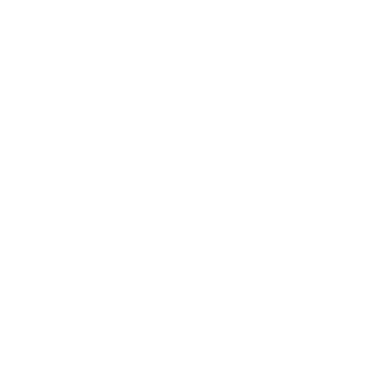

In [12]:
decoded = DS.one_hot_to_rgba(decoded_one_hot, mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


In [13]:
train_losses


[27089.379853377104]

In [14]:
test_losses


[7474.659069061279]

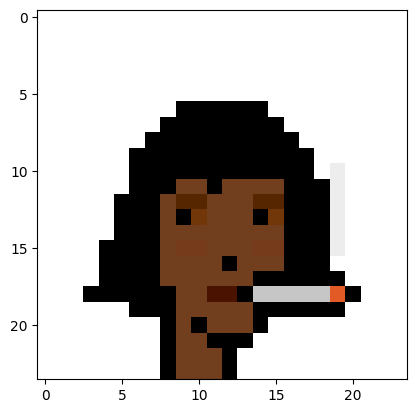

In [15]:
punk = I.get_punk_tensor(1000)

plt.imshow(transforms.functional.to_pil_image(punk))
plt.show()



torch.Size([1, 222, 24, 24])


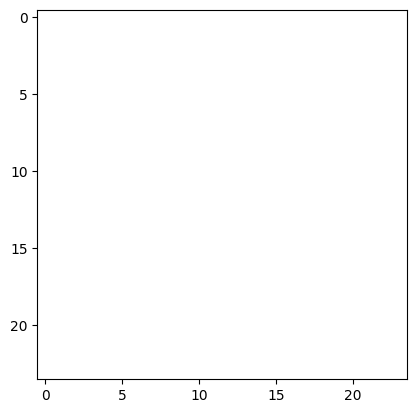

In [16]:
punk = I.get_punk_tensor(1000)

p = DS.rgba_to_one_hot(punk, mapper)
p = p.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu, logcar = model.forward(p)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, mapper)
plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

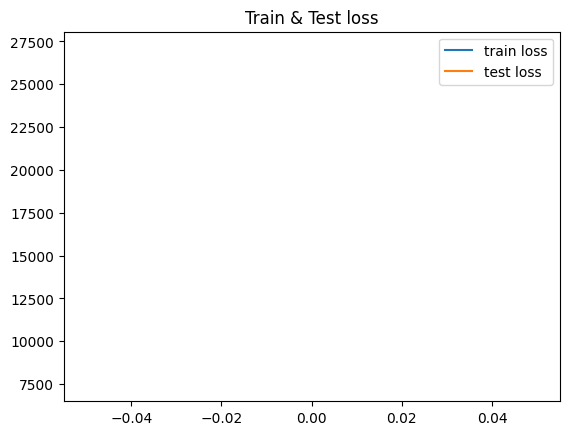

In [17]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
